In [89]:
## DATA MANIPULATION
import pandas as pd
import numpy as np

## PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

## STRING MANIPULATION
import re, string

## TF-IDF VECTORIZER
from sklearn.feature_extraction.text import TfidfVectorizer

## CLASSIFICATION
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_union
from sklearn.svm import LinearSVC

### Load Data and Explore

In [2]:
## LOAD DATA
data = pd.read_csv('../data/train.csv')
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
## EXAMPLE COMMENT
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

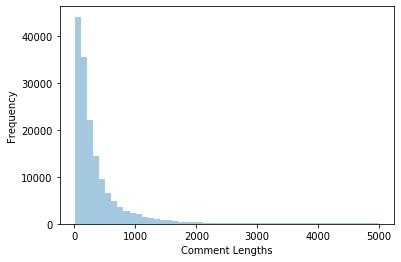

In [4]:
## CHECK LENGTHS OF COMMENTS
comment_lens = data['comment_text'].apply(len) # get comment lengths
ax = sns.distplot(comment_lens, kde=False)     # histogram 
ax.set_xlabel('Comment Lengths')
ax.set_ylabel('Frequency')
plt.show()

In [5]:
## CHECK LABEL DISTRIBUTION
labels = list(data.columns[2:])
data[labels].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

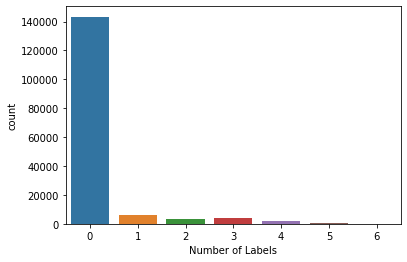

In [6]:
## CHECK NUMBER OF COMMENTS WITH MORE THAN 1 LABEL (MULTI-LABEL CLASSIFICATION)
nlabels = data[labels].sum(axis=1) # Get number of labels
ax = sns.countplot(nlabels)         # Count plot of labels
ax.set_xlabel('Number of Labels')
plt.show()

In [7]:
## REMOVE BLANK ROWS
data['comment_text'].fillna("unknown", inplace=True)

### SPLIT INTO TRAIN AND VALID SETS

In [8]:
train, valid = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)
X_train = train['comment_text']
X_valid = valid['comment_text']
print(X_train.shape, X_valid.shape)

(106912,) (52659,)


### CREATE BAG OF WORDS (BOW): TF-IDF VECTORIZER

In [98]:
## TOKENIZER
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train)      # vectorized train x
X_valid_vec = vectorizer.transform(X_valid)          # vectorized valid x

### BASELINE (LINEAR MODEL): NB-SVM
- based on Wang & Manning, 2012 (https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)
- A SVM model (liblinear) that takes transformed features using Naive Bayes' log-count ratio

In [101]:
## NB-SVM MODEL
def NB_SVM(x,y):
    y = y.values
    sum_1 = x[y==1].sum(axis=0)+1           # Feature Sum for Class 1
    p_1 = (sum_1) / ((y==1).sum())          # Convert to ratio of feature in class 1 - p(f|1)

    sum_0 = x[y==0].sum(axis=0)+1           # Feature Sum for Class 0
    p_0 = (sum_0) / ((y==0).sum())          # Convert to ratio of feature in class 0 - p(f|0) 

    r = np.log(p_1/p_0)                     # Compute log ratios (the transformation matrix)
    x_nb = x.multiply(r)                    # Obtain NB feature
    
    m = LinearSVC(class_weight='balanced')  # Balanced class weights [n_samples / n_classes * np.bincount(y)]
    m.fit(x_nb,y)                           # Fit model
    return m , r                            # return fitted model & transformation matrix (need for X_valid / X_test)

## CREATE A MODEL FOR EACH CATEGORY
for label in labels:
    # Get model and transformation matrix for category
    m,r = NB_SVM(X_train_vec, train[label])
    # Get predictions
    preds = m.predict(X_valid_vec.multiply(r))
    # Evaluate predictions
    print('Validation accuracy for {0} comments is {1:.2f}, with precision score of {2:.2f} and recall score of {3:.2f}'.format(
                                    label, 
                                    accuracy_score(valid[label], preds), 
                                    precision_score(valid[label], preds), 
                                    recall_score(valid[label], preds)))

Validation accuracy for toxic comments is 0.96, with precision score of 0.87 and recall score of 0.72
Validation accuracy for severe_toxic comments is 0.99, with precision score of 0.47 and recall score of 0.30
Validation accuracy for obscene comments is 0.98, with precision score of 0.87 and recall score of 0.75
Validation accuracy for threat comments is 1.00, with precision score of 0.69 and recall score of 0.31
Validation accuracy for insult comments is 0.97, with precision score of 0.79 and recall score of 0.63
Validation accuracy for identity_hate comments is 0.99, with precision score of 0.64 and recall score of 0.27
